In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../matplotlibrc')

In [41]:
matchups = pd.read_csv('matchups.csv', index_col=0)
matchups.index = pd.MultiIndex.from_tuples(list(zip(*(matchups['Dataset'], matchups['Model']))))
matchups['mean_final_mse'].unstack().rank(axis=1, method='min').mean(axis=0).sort_values().round(2)

SGBT          2.89
LightGBM      3.11
GBT           3.56
BRATD         4.11
Boulevard     4.22
XGBoost       4.33
RF            4.56
BRATP         6.33
ElasticNet    8.22
dtype: float64

In [42]:
(matchups['mean_final_mse'].unstack().rank(axis=1, method='min').astype(int) == 1).sum(0).sort_values(ascending=False)

GBT           4
LightGBM      4
SGBT          3
BRATD         2
RF            2
XGBoost       2
BRATP         1
Boulevard     1
ElasticNet    0
dtype: int64

In [8]:
matchups

,Dataset,Model,mean_final_mse,std_final_mse,n_runs
ID,,,,,
1,Abalone,LightGBM,4.813,0.000,5
1,Abalone,BRATD,4.905,0.005,5
1,Abalone,SGBT,4.934,0.067,5
1,Abalone,RF,4.937,0.024,5
1,Abalone,XGBoost,4.947,0.000,5
...,...,...,...,...,...
925,Infared Thermography Temperature,GBT,0.048,0.000,5
925,Infared Thermography Temperature,XGBoost,0.049,0.000,5
925,Infared Thermography Temperature,SGBT,0.050,0.002,5


In [203]:
import matplotlib.cm as cm
import glob
import os
#–– Prevent ptitprince cmap errors ––
cm.register_cmap = lambda *args, **kwargs: None
from matplotlib.ticker import FormatStrFormatter
import ptitprince as pt

#–– Palette & interval-to-label maps ––
palette = {
    "Built-In Confidence Interval": "#00BEFF",
    "Built-In Prediction Interval": "#F8766D",
    "Built-In Reproduction Interval": "#7CAE00",
    "Conformal Prediction Interval": "#C77CFF"
}

coverage_columns = {
    "ci_covered": "Built-In Confidence Interval",
    "pi_covered": "Built-In Prediction Interval",
    "ri_coverage": "Built-In Reproduction Interval",
    "cfml_covered": "Conformal Prediction Interval"
}

width_columns = {
    "ci_width":   "Built-In Confidence Interval",
    "pi_width":   "Built-In Prediction Interval",
    "ri_width":   "Built-In Reproduction Interval",
    "cfml_width": "Conformal Prediction Interval"
}

intervals = [
    "Built-In Confidence Interval",
    "Built-In Reproduction Interval",
    "Built-In Prediction Interval",
    "Conformal Prediction Interval"
]

#–– Directories ––
input_dir  = "../reports/coverage_rates_conformal_False/friedman1"

m_covs = []
m_widths = []
c_covs = []
c_widths = []
dfs = []
#–– Loop over every .parquet in the input directory ––
for pq_path in sorted(glob.glob(os.path.join(input_dir, "*.parquet"))):
    # 1) Load
    df = pd.read_parquet(pq_path)
    dfs.append(df)

    print(pq_path, str(df['sigma_hat'].mean()))

    # 2) Compute averages
    # marginal coverage rates (model avg cov / reps)
    m_covs.append(
        df
        .groupby("model_idx")[ list(coverage_columns.keys()) ]
        .mean()
        .reset_index()
    )
    m_widths.append(
        df
        .groupby("model_idx")[ list(width_columns.keys()) ]
        .mean()
        .reset_index()
    )
    # conditional coverage rates (per point coverage / test size)
    c_covs.append(
        df
        .groupby("pt_idx")[ list(coverage_columns.keys()) ]
        .mean()
        .reset_index()
    )
    c_widths.append(
        df
        .groupby("pt_idx")[ list(width_columns.keys()) ]
        .mean()
        .reset_index()
    )


../reports/coverage_rates_conformal_False/friedman1/npts_200_rep_30_epo_200_lr_0.6_sr_0.8_dr_0.0_md_4_nys_0.1_in_bag_False.parquet 5.24176463096597
../reports/coverage_rates_conformal_False/friedman1/npts_200_rep_30_epo_200_lr_0.6_sr_0.8_dr_0.1_md_4_nys_0.1_in_bag_False.parquet 5.251505123085268
../reports/coverage_rates_conformal_False/friedman1/npts_200_rep_30_epo_200_lr_0.6_sr_0.8_dr_0.2_md_4_nys_0.1_in_bag_False.parquet 5.262862163730365
../reports/coverage_rates_conformal_False/friedman1/npts_200_rep_30_epo_200_lr_0.6_sr_0.8_dr_0.3_md_4_nys_0.1_in_bag_False.parquet 5.278255959161008
../reports/coverage_rates_conformal_False/friedman1/npts_200_rep_30_epo_200_lr_0.6_sr_0.8_dr_0.4_md_4_nys_0.1_in_bag_False.parquet 5.291523781293535
../reports/coverage_rates_conformal_False/friedman1/npts_200_rep_30_epo_200_lr_0.6_sr_0.8_dr_0.5_md_4_nys_0.1_in_bag_False.parquet 5.310697667348034
../reports/coverage_rates_conformal_False/friedman1/npts_200_rep_30_epo_200_lr_0.6_sr_0.8_dr_0.6_md_4_nys_0

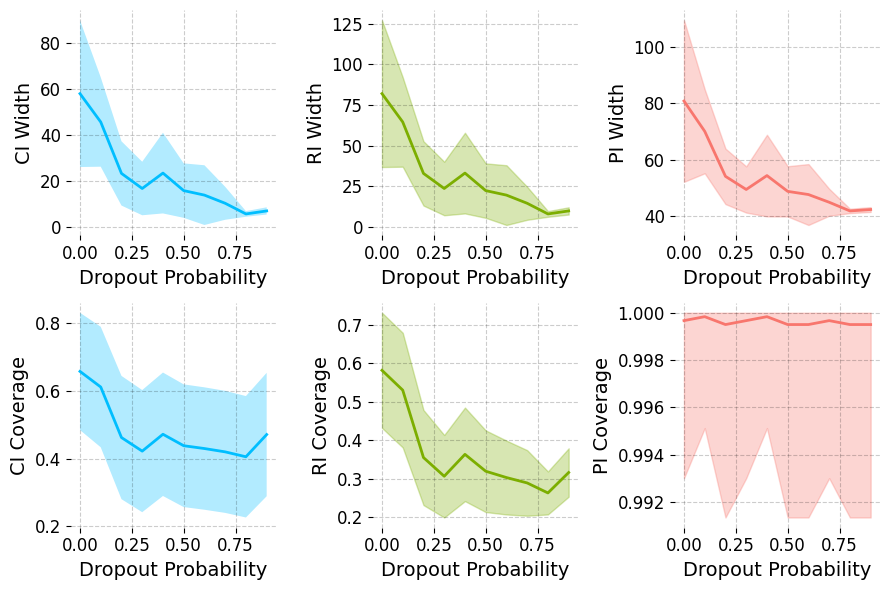

In [250]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,6))

## CIs
ax[0,0].plot(np.linspace(0,0.9,10), [np.mean(dfs[i]['ci_width']) for i in range(len(dfs))])
ax[0,0].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(dfs[i]['ci_width']) - 2*np.std(dfs[i]['ci_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(dfs[i]['ci_width']) + 2*np.std(dfs[i]['ci_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3)
ax[0,0].set_xlabel('Dropout Probability')
ax[0,0].set_ylabel('CI Width')

ax[1,0].plot(np.linspace(0,0.9,10), [np.mean(dfs[i]['ci_covered']) for i in range(len(dfs))])
ax[1,0].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(dfs[i]['ci_covered']) - 2*np.std(dfs[i]['ci_covered'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(dfs[i]['ci_covered']) + 2*np.std(dfs[i]['ci_covered'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3)
ax[1,0].set_xlabel('Dropout Probability')
ax[1,0].set_ylabel('CI Coverage')

## RIs
ax[0,1].plot(np.linspace(0,0.9,10), [np.mean(dfs[i]['ri_width']) for i in range(len(dfs))], color="#7CAE00")
ax[0,1].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(dfs[i]['ri_width']) - 2*np.std(dfs[i]['ri_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(dfs[i]['ri_width']) + 2*np.std(dfs[i]['ri_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#7CAE00")
ax[0,1].set_xlabel('Dropout Probability')
ax[0,1].set_ylabel('RI Width')

ax[1,1].plot(np.linspace(0,0.9,10), [np.mean(dfs[i]['ri_coverage']) for i in range(len(dfs))], color="#7CAE00")
ax[1,1].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(dfs[i]['ri_coverage']) - 2*np.std(dfs[i]['ri_coverage'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(dfs[i]['ri_coverage']) + 2*np.std(dfs[i]['ri_coverage'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#7CAE00")
ax[1,1].set_xlabel('Dropout Probability')
ax[1,1].set_ylabel('RI Coverage')

## PIs
ax[0,2].plot(np.linspace(0,0.9,10), [np.mean(dfs[i]['pi_width']) for i in range(len(dfs))], color="#F8766D")
ax[0,2].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(dfs[i]['pi_width']) - 2*np.std(dfs[i]['pi_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(dfs[i]['pi_width']) + 2*np.std(dfs[i]['pi_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#F8766D")
ax[0,2].set_xlabel('Dropout Probability')
ax[0,2].set_ylabel('PI Width')

ax[1,2].plot(np.linspace(0,0.9,10), [np.mean(dfs[i]['pi_covered']) for i in range(len(dfs))], color="#F8766D")
ax[1,2].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(dfs[i]['pi_covered']) - 2*np.std(dfs[i]['pi_covered'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.clip(np.mean(dfs[i]['pi_covered']) + 2*np.std(dfs[i]['pi_covered'])/np.sqrt(30), 0, 1) for i in range(len(dfs))],
                alpha=0.3, color="#F8766D")
ax[1,2].set_xlabel('Dropout Probability')
ax[1,2].set_ylabel('PI Coverage')
plt.tight_layout()

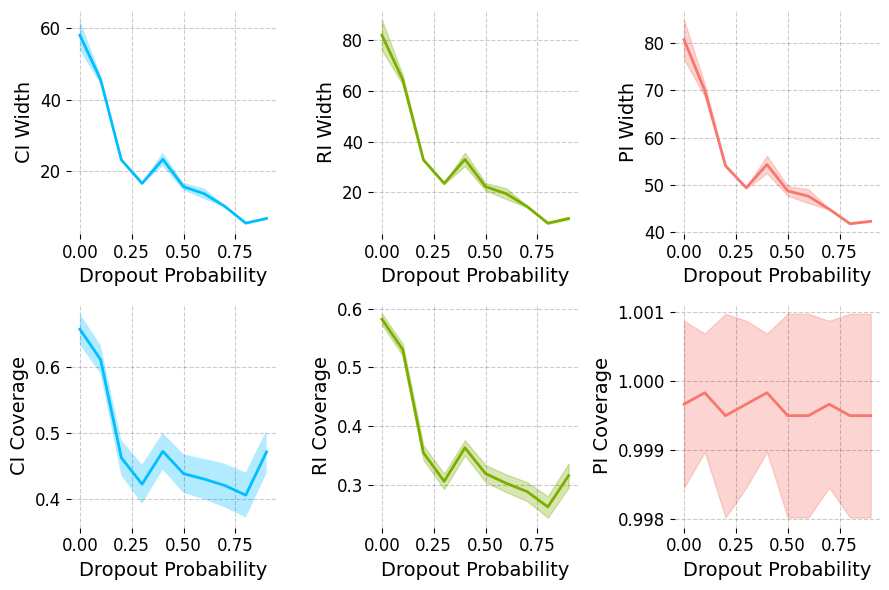

In [248]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,6))

## CIs
ax[0,0].plot(np.linspace(0,0.9,10), [np.mean(c_widths[i]['ci_width']) for i in range(len(dfs))])
ax[0,0].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(c_widths[i]['ci_width']) - 2*np.std(c_widths[i]['ci_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(c_widths[i]['ci_width']) + 2*np.std(c_widths[i]['ci_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3)
ax[0,0].set_xlabel('Dropout Probability')
ax[0,0].set_ylabel('CI Width')

ax[1,0].plot(np.linspace(0,0.9,10), [np.mean(c_covs[i]['ci_covered']) for i in range(len(dfs))])
ax[1,0].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(c_covs[i]['ci_covered']) - 2*np.std(c_covs[i]['ci_covered'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(c_covs[i]['ci_covered']) + 2*np.std(c_covs[i]['ci_covered'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3)
ax[1,0].set_xlabel('Dropout Probability')
ax[1,0].set_ylabel('CI Coverage')

## RIs
ax[0,1].plot(np.linspace(0,0.9,10), [np.mean(c_widths[i]['ri_width']) for i in range(len(dfs))], color="#7CAE00")
ax[0,1].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(c_widths[i]['ri_width']) - 2*np.std(c_widths[i]['ri_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(c_widths[i]['ri_width']) + 2*np.std(c_widths[i]['ri_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#7CAE00")
ax[0,1].set_xlabel('Dropout Probability')
ax[0,1].set_ylabel('RI Width')

ax[1,1].plot(np.linspace(0,0.9,10), [np.mean(c_covs[i]['ri_coverage']) for i in range(len(dfs))], color="#7CAE00")
ax[1,1].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(c_covs[i]['ri_coverage']) - 2*np.std(c_covs[i]['ri_coverage'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(c_covs[i]['ri_coverage']) + 2*np.std(c_covs[i]['ri_coverage'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#7CAE00")
ax[1,1].set_xlabel('Dropout Probability')
ax[1,1].set_ylabel('RI Coverage')

## PIs
ax[0,2].plot(np.linspace(0,0.9,10), [np.mean(c_widths[i]['pi_width']) for i in range(len(dfs))], color="#F8766D")
ax[0,2].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(c_widths[i]['pi_width']) - 2*np.std(c_widths[i]['pi_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(c_widths[i]['pi_width']) + 2*np.std(c_widths[i]['pi_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#F8766D")
ax[0,2].set_xlabel('Dropout Probability')
ax[0,2].set_ylabel('PI Width')

ax[1,2].plot(np.linspace(0,0.9,10), [np.mean(c_covs[i]['pi_covered']) for i in range(len(dfs))], color="#F8766D")
ax[1,2].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(c_covs[i]['pi_covered']) - 2*np.std(c_covs[i]['pi_covered'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(c_covs[i]['pi_covered']) + 2*np.std(c_covs[i]['pi_covered'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#F8766D")
ax[1,2].set_xlabel('Dropout Probability')
ax[1,2].set_ylabel('PI Coverage')
plt.tight_layout()

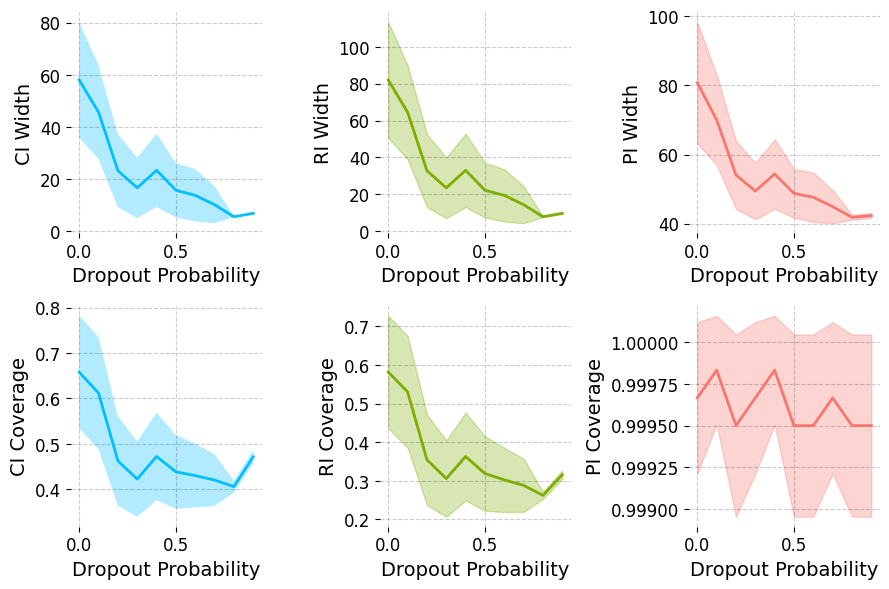

In [249]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,6))

## CIs
ax[0,0].plot(np.linspace(0,0.9,10), [np.mean(m_widths[i]['ci_width']) for i in range(len(dfs))])
ax[0,0].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(m_widths[i]['ci_width']) - 2*np.std(m_widths[i]['ci_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(m_widths[i]['ci_width']) + 2*np.std(m_widths[i]['ci_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3)
ax[0,0].set_xlabel('Dropout Probability')
ax[0,0].set_ylabel('CI Width')

ax[1,0].plot(np.linspace(0,0.9,10), [np.mean(m_covs[i]['ci_covered']) for i in range(len(dfs))])
ax[1,0].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(m_covs[i]['ci_covered']) - 2*np.std(m_covs[i]['ci_covered'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(m_covs[i]['ci_covered']) + 2*np.std(m_covs[i]['ci_covered'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3)
ax[1,0].set_xlabel('Dropout Probability')
ax[1,0].set_ylabel('CI Coverage')

## RIs
ax[0,1].plot(np.linspace(0,0.9,10), [np.mean(m_widths[i]['ri_width']) for i in range(len(dfs))], color="#7CAE00")
ax[0,1].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(m_widths[i]['ri_width']) - 2*np.std(m_widths[i]['ri_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(m_widths[i]['ri_width']) + 2*np.std(m_widths[i]['ri_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#7CAE00")
ax[0,1].set_xlabel('Dropout Probability')
ax[0,1].set_ylabel('RI Width')

ax[1,1].plot(np.linspace(0,0.9,10), [np.mean(m_covs[i]['ri_coverage']) for i in range(len(dfs))], color="#7CAE00")
ax[1,1].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(m_covs[i]['ri_coverage']) - 2*np.std(m_covs[i]['ri_coverage'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(m_covs[i]['ri_coverage']) + 2*np.std(m_covs[i]['ri_coverage'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#7CAE00")
ax[1,1].set_xlabel('Dropout Probability')
ax[1,1].set_ylabel('RI Coverage')

## PIs
ax[0,2].plot(np.linspace(0,0.9,10), [np.mean(m_widths[i]['pi_width']) for i in range(len(dfs))], color="#F8766D")
ax[0,2].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(m_widths[i]['pi_width']) - 2*np.std(m_widths[i]['pi_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(m_widths[i]['pi_width']) + 2*np.std(m_widths[i]['pi_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#F8766D")
ax[0,2].set_xlabel('Dropout Probability')
ax[0,2].set_ylabel('PI Width')

ax[1,2].plot(np.linspace(0,0.9,10), [np.mean(m_covs[i]['pi_covered']) for i in range(len(dfs))], color="#F8766D")
ax[1,2].fill_between(np.linspace(0,0.9,10), 
                 [np.mean(m_covs[i]['pi_covered']) - 2*np.std(m_covs[i]['pi_covered'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(m_covs[i]['pi_covered']) + 2*np.std(m_covs[i]['pi_covered'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#F8766D")
ax[1,2].set_xlabel('Dropout Probability')
ax[1,2].set_ylabel('PI Coverage')
plt.tight_layout()

In [259]:
pd.DataFrame({'CI width': [np.mean(dfs[i]['ci_width']).round(2) for i in range(len(dfs))],
              'CI coverage': [np.mean(dfs[i]['ci_covered']).round(2) for i in range(len(dfs))], 
              'PI width': [np.mean(dfs[i]['pi_width']).round(2) for i in range(len(dfs))],
              'PI coverage': [np.mean(dfs[i]['pi_covered']).round(5) for i in range(len(dfs))]},
            index = np.linspace(0,0.9,10))

,CI width,CI coverage,PI width,PI coverage
0.0,57.98,0.66,80.74,0.99967
0.1,45.62,0.61,70.02,0.99983
0.2,23.22,0.46,54.08,0.99950
0.3,16.66,0.42,49.43,0.99967
0.4,23.36,0.47,54.35,0.99983
0.5,15.73,0.44,48.76,0.99950
0.6,13.77,0.43,47.64,0.99950
0.7,10.21,0.42,44.90,0.99967
0.8,5.57,0.41,41.83,0.99950
0.9,6.88,0.47,42.33,0.99950


[0.66, 0.61, 0.46, 0.42, 0.47, 0.44, 0.43, 0.42, 0.41, 0.47]

In [243]:
[np.mean(dfs[i]['pi_width']).round(2) for i in range(len(dfs))]

[80.74, 70.02, 54.08, 49.43, 54.35, 48.76, 47.64, 44.9, 41.83, 42.33]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Text(0, 0.5, 'PI Width')

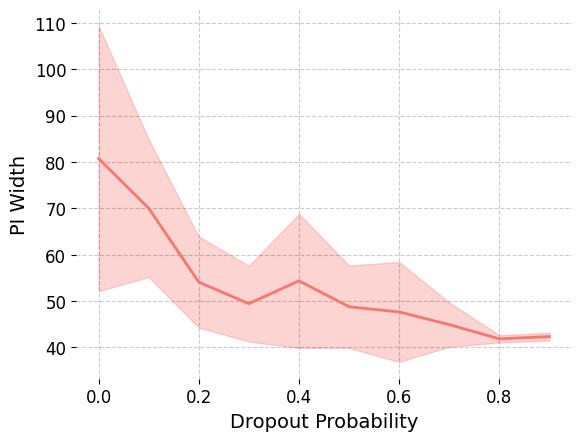

In [224]:
plt.plot(np.linspace(0,0.9,10), [np.mean(dfs[i]['pi_width']) for i in range(len(dfs))], color="#F8766D")
plt.fill_between(np.linspace(0,0.9,10), 
                 [np.mean(dfs[i]['pi_width']) - 2*np.std(dfs[i]['pi_width'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(dfs[i]['pi_width']) + 2*np.std(dfs[i]['pi_width'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#F8766D")
plt.xlabel('Dropout Probability')
plt.ylabel('PI Width')

Text(0, 0.5, 'CI Coverage')

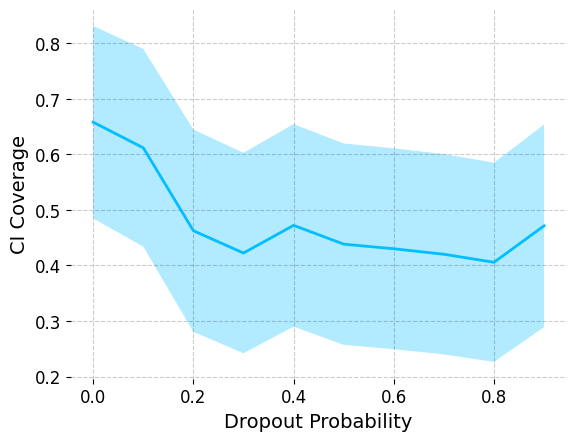

Text(0, 0.5, 'PI Coverage')

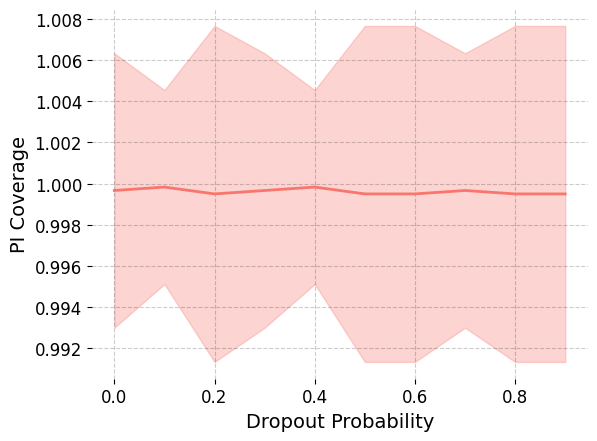

In [225]:
plt.plot(np.linspace(0,0.9,10), [np.mean(dfs[i]['pi_covered']) for i in range(len(dfs))], color="#F8766D")
plt.fill_between(np.linspace(0,0.9,10), 
                 [np.mean(dfs[i]['pi_covered']) - 2*np.std(dfs[i]['pi_covered'])/np.sqrt(30) for i in range(len(dfs))],
                 [np.mean(dfs[i]['pi_covered']) + 2*np.std(dfs[i]['pi_covered'])/np.sqrt(30) for i in range(len(dfs))],
                alpha=0.3, color="#F8766D")
plt.xlabel('Dropout Probability')
plt.ylabel('PI Coverage')

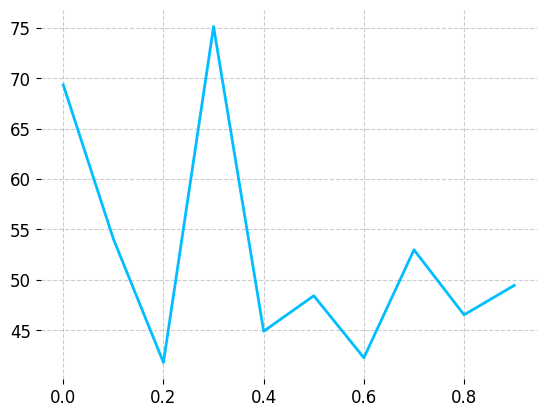

In [136]:
plt.plot(np.linspace(0,0.9,10), [np.median(c['pi_width']) for c in c_widths])
plt.show()

In [137]:
[np.std(c['pi_width']) for c in c_widths]

[3.543235860743874,
 0.07037169405036396,
 0.14088238383389662,
 11.300110748041966,
 0.1942012255741645,
 2.729725283546734,
 0.21289556952573557,
 5.048370443299732,
 4.026637562726934,
 0.27259841295750425]

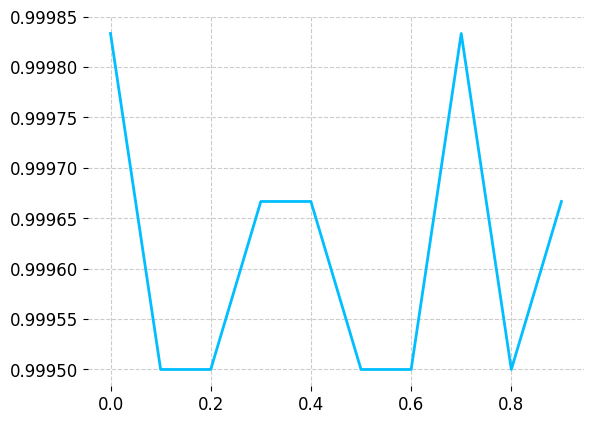

In [120]:
#plt.plot(np.linspace(0,0.9,10), [c['pi_covered'] for c in m_covs])
plt.plot(np.linspace(0,0.9,10), [c['pi_covered'].mean() for c in c_covs])
plt.show()

In [78]:
m_widths[0]

,model_idx,ci_width,pi_width,ri_width,cfml_width
0,0,35.933485,54.012474,50.817622,20.215843
1,1,111.841750,120.030547,158.168120,19.729842
2,2,96.536652,103.984761,136.523443,19.670796
3,3,96.282866,103.332477,136.164535,19.814651
4,4,4.129707,39.829053,5.840288,20.324853
5,5,3.864119,41.176914,5.464690,20.713677
6,6,3.765086,40.352257,5.324636,21.934734
7,7,4.198981,43.173434,5.938256,20.233924
8,8,3.908582,39.593071,5.527569,20.533583
9,9,4.123538,41.337184,5.831563,17.558470
